In [ ]:
import os
import cv2   #opencv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [ ]:
!pip install Pillow
from PIL import Image

In [ ]:
labels_dict = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma': 5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis': 7,
    'Vascular lesion': 8
}

In [ ]:
data_dir = '/content/drive/MyDrive/Split_smol/train'

In [ ]:
X = []
y = []

for folder, label in labels_dict.items():
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        print(f"Directory '{folder}' not found in '{data_dir}'. Skipping...")
        continue

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}. Skipping...")
            continue

        img = cv2.resize(img, (227, 227))  # Resize images to (227, 227)
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]   #shuffle to unsure that train and testing data will not follow same order

# Split the data into training and validation sets
split_index = int(0.8 * len(X_shuffled))  # Use 80% of the data for training
X_train, X_val = X_shuffled[:split_index], X_shuffled[split_index:]
y_train, y_val = y_shuffled[:split_index], y_shuffled[split_index:]

In [ ]:
datagen = ImageDataGenerator(          #data augumentation
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print(len(train_generator))
print(len(val_generator))

18
5


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(227, 227, 3))   #googlenet

In [ ]:
for layer in base_model.layers:
    layer.trainable = False        #to freeze the data for no longer changes


In [ ]:

x = base_model.output
x = GlobalAveragePooling2D()(x)          # x is input
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels_dict), activation='softmax')(x)   #softmax - gives probability distribution to determine the class


In [ ]:
model = Model(inputs=base_model.input, outputs=output)


In [ ]:

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


In [ ]:

history = model.fit(
    train_generator,
    epochs=20,     #the number of training iterations (epochs) the model will go through.
    validation_data=val_generator
)


Epoch 1/20
18/18 [==============================] - 143s 7s/step - loss: 2.3953 - accuracy: 0.2424 - val_loss: 1.6695 - val_accuracy: 0.3714
Epoch 2/20
18/18 [==============================] - 121s 7s/step - loss: 1.6880 - accuracy: 0.4093 - val_loss: 1.4271 - val_accuracy: 0.4571
Epoch 3/20
18/18 [==============================] - 105s 6s/step - loss: 1.5155 - accuracy: 0.4776 - val_loss: 1.3616 - val_accuracy: 0.5000
Epoch 4/20
18/18 [==============================] - 104s 6s/step - loss: 1.3994 - accuracy: 0.5189 - val_loss: 1.3057 - val_accuracy: 0.5214
Epoch 5/20
18/18 [==============================] - 102s 6s/step - loss: 1.2829 - accuracy: 0.5637 - val_loss: 1.2554 - val_accuracy: 0.5286
Epoch 6/20
18/18 [==============================] - 124s 7s/step - loss: 1.2704 - accuracy: 0.5404 - val_loss: 1.2809 - val_accuracy: 0.5214
Epoch 7/20
18/18 [==============================] - 123s 7s/step - loss: 1.2300 - accuracy: 0.5655 - val_loss: 1.1824 - val_accuracy: 0.5786
Epoch 8/20
18

In [ ]:

test_loss, test_accuracy = model.evaluate(val_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

5/5 [==============================] - 22s 4s/step - loss: 1.0202 - accuracy: 0.6143
Test loss: 1.020193099975586
Test accuracy: 0.6142857074737549


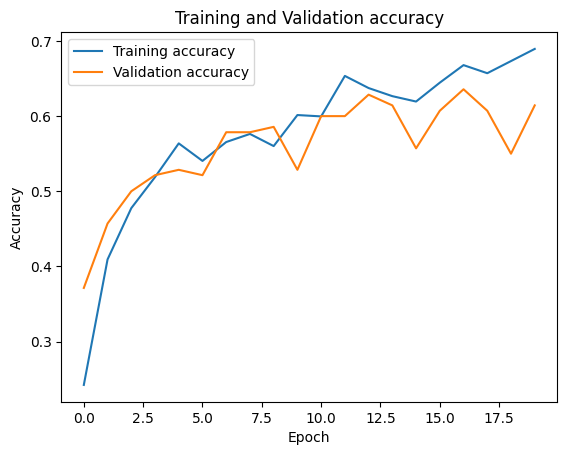

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
model.save('skin_diseases_model_inceptionv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('skin_diseases_model_inceptionv3.h5')

In [ ]:
import PIL
image_path = '/content/drive/MyDrive/Split_smol/train/Melanoma/ISIC_0000002.jpg'
test_image = PIL.Image.open(image_path)
resized_image = test_image.resize((227, 227))
resized_image = np.array(resized_image) / 255.0
resized_image = resized_image[np.newaxis, ...]
prediction = new_model.predict(resized_image)
predicted_class_index = np.argmax(prediction)
print('Predicted class index:', predicted_class_index)

1/1 [==============================] - 3s 3s/step
Predicted class index: 5


In [ ]:
predicted_label = {v: k for k, v in labels_dict.items()}.get(predicted_class_index)
print('Predicted label:', predicted_label)

Predicted label: Melanoma
